In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Dissertation/data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from my_method import *
from TOPUP import *
from data_generation import *
from tensor_operation import *
import math
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

## Aggregate Data

In [ ]:
# Countries code
# USA, China, Japan, Germany, UK, France, India, Italy, Canada
countries = ['842', '156', '392', '276', '826', '251', '699', '381', '124']
total_data = np.zeros(120*9*9*15).reshape(120,9,9,15)
for i in range(1,10):
  file_name = 'data_' + str(i) + '.npy'
  data = np.load(file_name)
  total_data[:,i-1,:,:] = data

## 3-month moving average

In [ ]:
mov_ave = np.zeros(118*9*9*15).reshape(118,9,9,15)
for i in range(1,119):
  mov_ave[i-1,:,:,:] = (total_data[i-1,:,:,:]+total_data[i,:,:,:]+total_data[i+1,:,:,:])/3 

In [ ]:
# Centralized
mean = np.sum(mov_ave,axis=0) * (1/118)
centered_tensor = mov_ave - mean

## TOPUP

In [ ]:
# 1.TOPUP_k
def tensor_unfolding(tensor, k):
  #-------
  # k:mode-k unfolding
  #-------
  n,d_1,d_2,d_3 = tensor.shape
  if k == 1:
    mat = np.reshape(tensor, newshape=(n,d_1,d_2*d_3), order='F')
  if k == 2:
    t_1 = np.swapaxes(tensor, 2, 1)
    mat = np.reshape(t_1, newshape=(n,d_2,d_1*d_3), order='F')
  if k == 3:
    t_1 = np.swapaxes(tensor, 1, 3)
    t_2 = np.swapaxes(tensor, 2, 3)
    mat = np.reshape(t_2, newshape=(n,d_3,d_1*d_2), order='F')
  return (mat)

def topup_k(mat):
  # determine dimensions
  n,d_k,d_ = mat.shape
  mat_1 = mat[:-1,:,:]
  mat_2 = mat[1:,:,:]
  mat_3 = mat[:-2,:,:]
  mat_4 = mat[2:,:,:]
  tensor_product_1 = np.ones((n-1)*(d_k*d_)**2).reshape((n-1),d_k,d_,d_k,d_)
  tensor_product_2 = np.ones((n-2)*(d_k*d_)**2).reshape((n-2),d_k,d_,d_k,d_)
  for r_1 in range(d_k):
    for r_2 in range(d_):
      for r_3 in range(d_k):
        for r_4 in range(d_):
          tensor_product_1[:,r_1,r_2,r_3,r_4] = mat_1[:,r_1,r_2]*mat_2[:,r_3,r_4]
          tensor_product_2[:,r_1,r_2,r_3,r_4] = mat_3[:,r_1,r_2]*mat_4[:,r_3,r_4]
  topup_k = np.zeros(2*(d_k*d_)**2).reshape(d_k,d_,d_k,d_,2)
  topup_k[:,:,:,:,0] = np.sum(tensor_product_1,axis=0) * (1/(n-1))
  topup_k[:,:,:,:,1] = np.sum(tensor_product_2,axis=0) * (1/(n-2))
  return topup_k

In [ ]:
# 2.Calculate W_k and operate eigenvalue decomposition
def TOPUP(topup_k):
  d_k,d_,h = topup_k.shape[-3:]
  mat = topup_k.reshape(d_k,d_*d_*d_k*h)
  w_k = np.dot(mat,mat.T)

  eigen_vals, eigen_vecs = np.linalg.eig(w_k)
  ratio = list(eigen_vals[0:d_k-1]/eigen_vals[1:d_k])
  max_index = ratio.index(max(ratio))
  estimated_r = max_index + 1
  #loading_matrix = eigen_vecs[:,0:estimated_r]
  return [eigen_vals,eigen_vecs,estimated_r]

In [ ]:
# 3.Get results
result_1 = TOPUP(topup_k(tensor_unfolding(centered_tensor, 1)))
result_2 = TOPUP(topup_k(tensor_unfolding(centered_tensor, 2)))
result_3 = TOPUP(topup_k(tensor_unfolding(centered_tensor, 3)))

In [ ]:
A_1 = result_1[1][:,0:2]
A_2 = result_2[1][:,0:2]
A_3 = result_3[1][:,0:4]

## Varimax rotation

In [ ]:
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
  from scipy.linalg import svd
  p,k = Phi.shape
  R = np.eye(k)
  d=0
  for i in range(q):
    d_old = d
    Lambda = np.dot(Phi, R)
    u,s,vh = svd(np.dot(Phi.T,np.asarray(Lambda)**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
    R = np.dot(u,vh)
    d = np.sum(s)
    if d_old!=0 and d/d_old < 1 + tol: break
  return np.dot(Phi, R)

In [ ]:
def column_normalize(matrix_):
  c = matrix_.shape[1]
  new_matrix = matrix_.copy()
  summation = np.sum(matrix_,axis=0)
  for i in range(c):
    new_matrix[:,i] = matrix_[:,i]*(1/summation[i])
  return new_matrix

In [ ]:
# clearer view
base_1 = np.round_(column_normalize(varimax(A_1))*100)
base_2 = np.round_(column_normalize(varimax(A_2))*100)
base_3 = np.round_(varimax(A_3)*100)

## Method one

In [ ]:
## 1.Matrix-leveled estimator
def mat_leveled(centered_tensor,k):
  n,d_1,d_2,d_3 = centered_tensor.shape
  
  if k==1:
    mat_estimator = np.zeros(d_1*d_1).reshape(d_1,d_1)
    for j in range(d_1):
      for i in range(d_1):
        mat_estimator[i,j] = np.sum(centered_tensor[:,i,:,:] * centered_tensor[:,j,:,:])
    sample_version = mat_estimator*(1/n)
    
  if k==2:
    mat_estimator = np.zeros(d_2*d_2).reshape(d_2,d_2)
    for j in range(d_2):
      for i in range(d_2):
        mat_estimator[i,j] = np.sum(centered_tensor[:,:,i,:] * centered_tensor[:,:,j,:])
    sample_version = mat_estimator*(1/n)  
    
  if k==3:
    mat_estimator = np.zeros(d_3*d_3).reshape(d_3,d_3)
    for j in range(d_3):
      for i in range(d_3):
        mat_estimator[i,j] = np.sum(centered_tensor[:,:,:,i] * centered_tensor[:,:,:,j])
    sample_version = mat_estimator*(1/n)  
    
  return sample_version

In [ ]:
def method_one(sample_version):
  l = sample_version.shape[0]
  eigen_vals, eigen_vecs = np.linalg.eig(sample_version)
  ratio = list(eigen_vals[0:l-1]/eigen_vals[1:l])
  max_index = ratio.index(max(ratio))
  estimated_r = max_index + 1
  #loading_matrix = eigen_vecs[:,0:estimated_r]
  return [eigen_vals,eigen_vecs,estimated_r]          

In [ ]:
# 2.Get results
result_21 = method_one(mat_leveled(centered_tensor,1))
result_22 = method_one(mat_leveled(centered_tensor,2))
result_23 = method_one(mat_leveled(centered_tensor,3))

In [ ]:
A_21 = result_21[1][:,0:3]
A_22 = result_22[1][:,0:3]
A_23 = result_23[1][:,0:4]

In [ ]:
# 3.Clearer view
base_21 = np.round_(column_normalize(varimax(A_21))*100)
base_22 = np.round_(column_normalize(varimax(A_22))*100)
base_23 = np.round_(varimax(A_23)*100)

## Method two

In [ ]:
# transform centered_tensor
tran_tensor = np.swapaxes(centered_tensor, 1, 3)
# (n,product,import,export)(nsimulations,d_3,d_2,d_1)
tran_tensor.shape

(118, 15, 9, 9)

In [ ]:
# 2.Get results
covariance = tensor_cov(tran_tensor)
results = HOOI(covariance,9,9,15,3,3,4)

In [ ]:
A_31 = results[1]
A_32 = results[2]
A_33 = results[3]

In [ ]:
# 3.Clearer view
base_31 = np.round_(column_normalize(varimax(A_31))*100)
base_32 = np.round_(column_normalize(varimax(A_32))*100)
base_33 = np.round_(varimax(A_33)*100)

## Hierarchy clustering

In [ ]:
import scipy
import scipy.cluster.hierarchy as sch
from scipy.cluster.vq import vq,kmeans,whiten

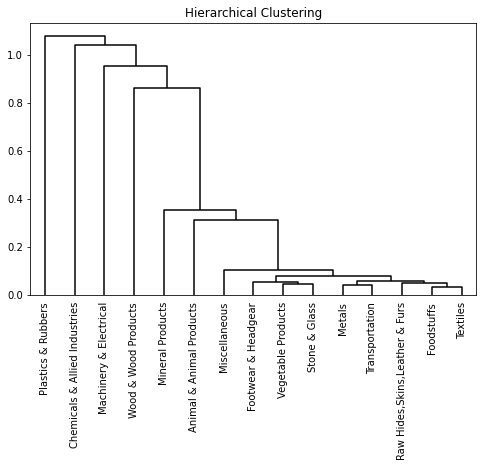

In [ ]:
# labels
lab = ['Animal & Animal Products','Vegetable Products','Foodstuffs','Mineral Products','Chemicals & Allied Industries',
       'Plastics & Rubbers','Raw Hides,Skins,Leather & Furs','Wood & Wood Products','Textiles','Footwear & Headgear','Stone & Glass',
       'Metals','Machinery & Electrical','Transportation','Miscellaneous']
# TOPUP
disMat = sch.distance.pdist(A_3,'euclidean')
Z=sch.linkage(disMat,method='average')
# plot
fig = plt.figure(figsize=(8,5))
P = sch.dendrogram(Z,labels=lab,color_threshold=0.0,above_threshold_color='black')
plt.xticks(rotation=90, fontsize=10)
plt.title('Hierarchical Clustering')
plt.show()

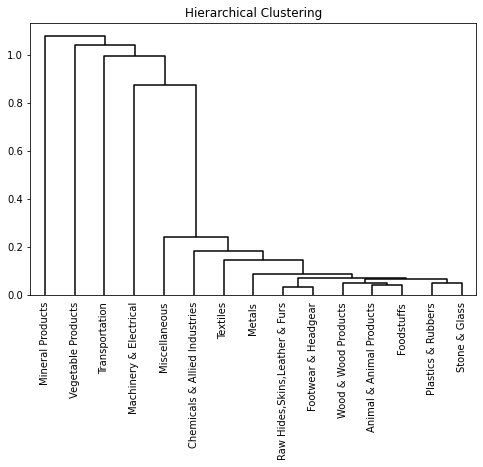

In [ ]:
# Method one
disMat = sch.distance.pdist(A_23,'euclidean')
Z=sch.linkage(disMat,method='average')
# plot
fig = plt.figure(figsize=(8,5))
P = sch.dendrogram(Z,labels=lab,color_threshold=0.0,above_threshold_color='black',)
plt.xticks(rotation=90, fontsize=10)
plt.title('Hierarchical Clustering')
plt.show()

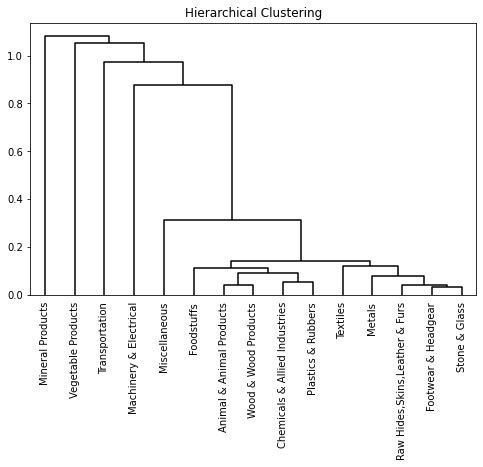

In [ ]:
# Method two
disMat = sch.distance.pdist(A_33,'euclidean')
Z=sch.linkage(disMat,method='average')
# plot
fig = plt.figure(figsize=(8,5))
P = sch.dendrogram(Z,labels=lab,color_threshold=0.0,above_threshold_color='black',)
plt.xticks(rotation=90, fontsize=10)
plt.title('Hierarchical Clustering')
plt.show()

## Trading Hub

In [ ]:
# For import hub
# [0][1][2,3,8]
t = KMeans(n_clusters=4, random_state=0).fit(A_22)
t.labels_

array([2, 3, 1, 1, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
# product_1
product_1 = np.sum(total_data[95:119,:,:,1],axis=0)
# export
print(product_1[:,0] * (1/sum(product_1[:,0])) *100)
print(product_1[:,1] * (1/sum(product_1[:,1])) *100)
print(product_1[:,8] * (1/sum(product_1[:,8])) *100)
# import
print(product_1[0,:] * (1/sum(product_1[0,:])) *100)
print(product_1[1,:] * (1/sum(product_1[1,:])) *100)

[ 0.         11.32209587  1.16642362  5.71776019  0.88867028  2.21861859
 11.23161813  6.25351298 61.20130034]
[53.67399987  0.          1.11070704  0.68552979  0.26759292  2.36494309
  6.29832696  0.94724028 34.65166005]
[92.14523178  2.77988762  0.15266771  0.70360694  0.3127567   0.27685031
  2.03983969  1.58915925  0.        ]
[ 0.         25.61306279 23.69113024  4.42284896  2.5654439   1.3544565
  3.48392388  3.11555797 35.75357577]
[27.95874047  0.         43.67899799  9.15418387  4.27311375  2.73715171
  3.21757143  3.72266537  5.25757541]


In [ ]:
print(sum(product_1[[2,3,8],:] * (1/sum(sum(product_1[[2,3,8],:])))*100))

[45.42474754 22.90492633 10.16949814  0.80526434  5.05907228  8.58052967
  1.26487871  5.35354218  0.43754082]


## Plot

In [ ]:
# Firstly write a function to compute the factor
def factor(data, a_1,a_2,a_3):
    # ----------------------------
    # data: real tensor time series
    # a_1, a_2, a_3; estimated loading matrices
    # ____________________________
    
    # dimension recognition
    n,d_1,d_2,d_3 = data.shape
    r_1 = a_1.shape[1]
    r_2 = a_2.shape[1]
    r_3 = a_3.shape[1]
    
    # compute factors
    product_1 = np.zeros(r_1*d_2*d_3*n).reshape(n,r_1,d_2,d_3)
    for i in range(r_1):
      for j in range(d_1):
        product_1[:,i,:,:] += data[:,j,:,:] * a_1[j,i]
            
    product_2 = np.zeros(r_1*r_2*d_3*n).reshape(n,r_1,r_2,d_3)
    for i in range(r_2):
      for j in range(d_2):
        product_2[:,:,i,:] += product_1[:,:,j,:] * a_2[j,i]
    
    factor = np.zeros(r_1*r_2*r_3*n).reshape(n,r_1,r_2,r_3)        
    for i in range(r_3):
      for j in range(d_3):
        factor[:,:,:,i] += product_2[:,:,:,j] * a_3[j,i]
    
    return factor

In [ ]:
factor = factor(total_data,A_31,A_32,A_33)

In [ ]:
# date
date = np.array(range(120)).tolist()
def draw(y, ith):
  plt.subplot(3, 3, ith)
  plt.plot(date, y, linewidth = 1.2)
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)

<function matplotlib.pyplot.show>

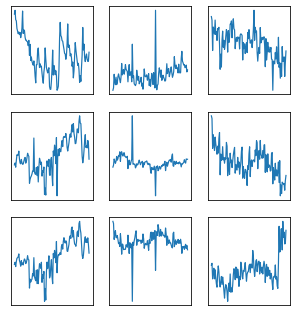

In [ ]:
plt.figure(figsize=(5, 5.5))
draw(y=factor[:,0,0,0].tolist(), ith=1)
draw(y=factor[:,1,0,0].tolist(), ith=2)
draw(y=factor[:,2,0,0].tolist(), ith=3)
draw(y=factor[:,0,1,0].tolist(), ith=4)
draw(y=factor[:,1,1,0].tolist(), ith=5)
draw(y=factor[:,2,1,0].tolist(), ith=6)
draw(y=factor[:,0,2,0].tolist(), ith=7)
draw(y=factor[:,1,2,0].tolist(), ith=8)
draw(y=factor[:,2,2,0].tolist(), ith=9)
plt.show

<function matplotlib.pyplot.show>

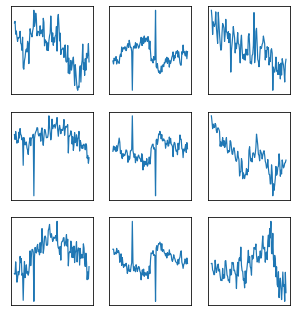

In [ ]:
plt.figure(figsize=(5, 5.5))
draw(y=factor[:,0,0,1].tolist(), ith=1)
draw(y=factor[:,1,0,1].tolist(), ith=2)
draw(y=factor[:,2,0,1].tolist(), ith=3)
draw(y=factor[:,0,1,1].tolist(), ith=4)
draw(y=factor[:,1,1,1].tolist(), ith=5)
draw(y=factor[:,2,1,1].tolist(), ith=6)
draw(y=factor[:,0,2,1].tolist(), ith=7)
draw(y=factor[:,1,2,1].tolist(), ith=8)
draw(y=factor[:,2,2,1].tolist(), ith=9)
plt.show

<function matplotlib.pyplot.show>

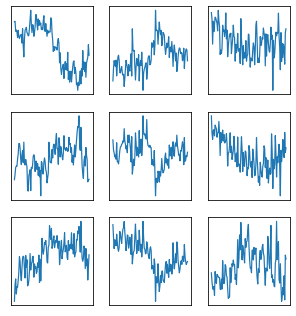

In [ ]:
plt.figure(figsize=(5, 5.5))
draw(y=factor[:,0,0,2].tolist(), ith=1)
draw(y=factor[:,1,0,2].tolist(), ith=2)
draw(y=factor[:,2,0,2].tolist(), ith=3)
draw(y=factor[:,0,1,2].tolist(), ith=4)
draw(y=factor[:,1,1,2].tolist(), ith=5)
draw(y=factor[:,2,1,2].tolist(), ith=6)
draw(y=factor[:,0,2,2].tolist(), ith=7)
draw(y=factor[:,1,2,2].tolist(), ith=8)
draw(y=factor[:,2,2,2].tolist(), ith=9)
plt.show

<function matplotlib.pyplot.show>

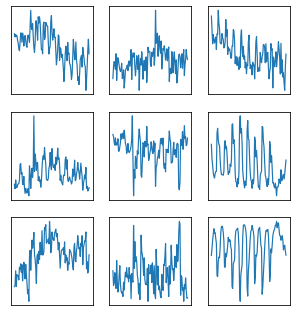

In [ ]:
plt.figure(figsize=(5, 5.5))
draw(y=factor[:,0,0,3].tolist(), ith=1)
draw(y=factor[:,1,0,3].tolist(), ith=2)
draw(y=factor[:,2,0,3].tolist(), ith=3)
draw(y=factor[:,0,1,3].tolist(), ith=4)
draw(y=factor[:,1,1,3].tolist(), ith=5)
draw(y=factor[:,2,1,3].tolist(), ith=6)
draw(y=factor[:,0,2,3].tolist(), ith=7)
draw(y=factor[:,1,2,3].tolist(), ith=8)
draw(y=factor[:,2,2,3].tolist(), ith=9)
plt.show